<a href="https://colab.research.google.com/github/iamatul1214/LLMs/blob/main/Positional_Encoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. What is positional encoding?

Transformers have no sense of order.
So we add a vector that encodes the position of each token.

For token at index ```pos```   , dimension ```i```:


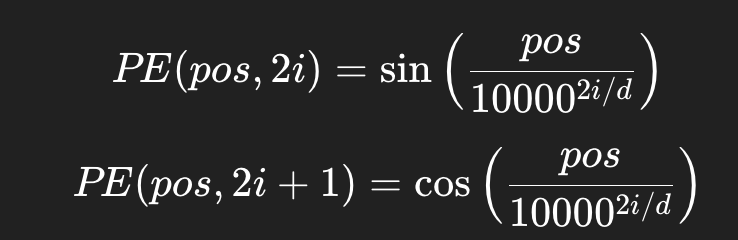

## This creates:

- A unique vector for each position

- A pattern that lets the model learn distances between positions

- Infinite extrapolation (no upper limit)

## Simple Python Example (Positional Encoding with NumPy)

Positional Vector at pos=0:
 [0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.]

Positional Vector at pos=1:
 [8.41470985e-01 5.40302306e-01 3.10983593e-01 9.50415280e-01
 9.98334166e-02 9.95004165e-01 3.16175064e-02 9.99500042e-01
 9.99983333e-03 9.99950000e-01 3.16227239e-03 9.99995000e-01
 9.99999833e-04 9.99999500e-01 3.16227761e-04 9.99999950e-01]

Positional Vector at pos=10:
 [-0.54402111 -0.83907153 -0.02068353 -0.99978607  0.84147098  0.54030231
  0.31098359  0.95041528  0.09983342  0.99500417  0.03161751  0.99950004
  0.00999983  0.99995     0.00316227  0.999995  ]


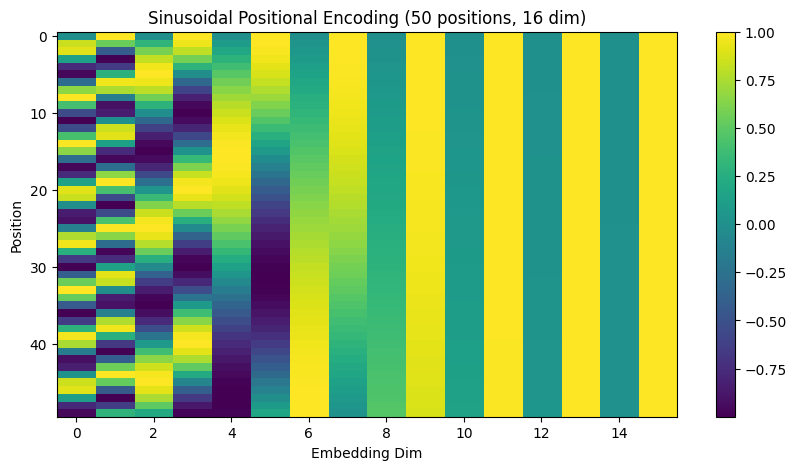

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def positional_encoding(max_len, d_model):
    PE = np.zeros((max_len, d_model))

    positions = np.arange(max_len)[:, np.newaxis]     # shape (max_len, 1)
    dims = np.arange(d_model)[np.newaxis, :]          # shape (1, d_model)

    angles = positions / np.power(10000, (2 * (dims//2)) / d_model)

    PE[:, 0::2] = np.sin(angles[:, 0::2])  # even indices
    PE[:, 1::2] = np.cos(angles[:, 1::2])  # odd indices

    return PE

# Generate encoding for 50 positions, embedding dimension = 16
PE = positional_encoding(50, 16)

print("Positional Vector at pos=0:\n", PE[0])
print("\nPositional Vector at pos=1:\n", PE[1])
print("\nPositional Vector at pos=10:\n", PE[10])

# Visualization
plt.figure(figsize=(10,5))
plt.imshow(PE, cmap='viridis', aspect='auto')
plt.colorbar()
plt.title("Sinusoidal Positional Encoding (50 positions, 16 dim)")
plt.xlabel("Embedding Dim")
plt.ylabel("Position")
plt.show()


## Now let's see a practical implementation of positional encoding using transformer by

- building two tiny Transformer models (same architecture),

- one without positional encoding (NoPE),

- one with sinusoidal positional encoding (PE),

- trains both on the same short sentence for next-token prediction,

- extracts per-head attention scores from tf.keras.layers.MultiHeadAttention,

- shows side-by-side heatmaps (PE vs NoPE) so you can visually compare how positional encoding changes attention patterns,

- prints the softmax probabilities for a chosen query position so you can see numeric effects.

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.special

# reproducibility
tf.random.set_seed(0)
np.random.seed(0)

# ---------------------------
# Positional Encoding Layer
# ---------------------------
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, max_len, d_model):
        super().__init__()
        pos = np.arange(max_len)[:, np.newaxis]
        dims = np.arange(d_model)[np.newaxis, :]
        angles = pos / np.power(10000, (2 * (dims // 2)) / d_model)
        PE = np.zeros((max_len, d_model), dtype=np.float32)
        PE[:, 0::2] = np.sin(angles[:, 0::2])
        PE[:, 1::2] = np.cos(angles[:, 1::2])
        self.pos_encoding = tf.constant(PE)  # (max_len, d_model)

    def call(self, x):
        seq_len = tf.shape(x)[1]
        return x + self.pos_encoding[:seq_len, :]

# ---------------------------
# Tiny transformer model factory
# ---------------------------
def make_tiny_transformer(vocab_size, d_model=32, num_heads=4, ff_dim=64, use_pos_enc=False, max_len=64):
    inp = tf.keras.Input(shape=(None,), dtype=tf.int32)  # (batch, seq)
    embed = tf.keras.layers.Embedding(vocab_size, d_model)(inp)  # (batch, seq, d_model)
    x = embed
    if use_pos_enc:
        x = PositionalEncoding(max_len, d_model)(x)

    # single MultiHeadAttention layer (we will call it directly to get attn scores later)
    mha_layer = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model // num_heads)
    att_out = mha_layer(query=x, value=x, key=x, return_attention_scores=False)  # (batch, seq, d_model)
    x = tf.keras.layers.Add()([x, att_out])
    x = tf.keras.layers.LayerNormalization()(x)

    ff = tf.keras.Sequential([
        tf.keras.layers.Dense(ff_dim, activation='relu'),
        tf.keras.layers.Dense(d_model)
    ])
    ff_out = ff(x)
    x = tf.keras.layers.Add()([x, ff_out])
    x = tf.keras.layers.LayerNormalization()(x)

    logits = tf.keras.layers.Dense(vocab_size)(x)  # (batch, seq, vocab)
    model = tf.keras.Model(inputs=inp, outputs=logits)
    # return also the mha layer so we can call it with return_attention_scores later
    return model, mha_layer

# ---------------------------
# UI: get sentence & build vocab
# ---------------------------
sentence = input("Enter a short sentence (3-12 words recommended):\n> ").strip()
tokens = sentence.split()
if len(tokens) < 2:
    raise ValueError("Enter at least two tokens (words).")

# Make a deterministic small vocab (preserve order)
vocab = list(dict.fromkeys(tokens))  # unique in order
stoi = {w:i for i,w in enumerate(vocab)}
itos = {i:w for w,i in stoi.items()}

# Prepare data (single sample)
token_ids = np.array([[stoi[w] for w in tokens]], dtype=np.int32)  # (1, seq)
inputs = token_ids[:, :-1]   # predict next token for each position
targets = token_ids[:, 1:]

batch = inputs.shape[0]
seq_len = inputs.shape[1]
vocab_size = len(vocab)

print(f"\nVocab: {vocab}")
print("Inputs shape:", inputs.shape, "Targets shape:", targets.shape)

# ---------------------------
# Build two models: NoPE and PE
# ---------------------------
d_model = 32
num_heads = 4
ff_dim = 64
max_len = 64

model_nope, mha_nope = make_tiny_transformer(vocab_size, d_model, num_heads, ff_dim, use_pos_enc=False, max_len=max_len)
model_pe,   mha_pe   = make_tiny_transformer(vocab_size, d_model, num_heads, ff_dim, use_pos_enc=True,  max_len=max_len)

# compile (we'll use custom loop to fetch attention scores, but compile for convenience)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
opt_nope = tf.keras.optimizers.Adam(1e-3)
opt_pe   = tf.keras.optimizers.Adam(1e-3)

# Warm-up call to build weights
_ = model_nope(inputs)
_ = model_pe(inputs)

# ---------------------------
# Training loop (small)
# ---------------------------
steps = 300
print("\nTraining both models for", steps, "steps (this is small).")

for step in range(steps):
    # --- train NoPE ---
    with tf.GradientTape() as tape:
        logits_nope = model_nope(inputs, training=True)  # (1, seq, vocab)
        loss_nope = loss_fn(targets.reshape(-1), tf.reshape(logits_nope, [-1, vocab_size]))
    grads = tape.gradient(loss_nope, model_nope.trainable_variables)
    opt_nope.apply_gradients(zip(grads, model_nope.trainable_variables))

    # --- train PE ---
    with tf.GradientTape() as tape:
        logits_pe = model_pe(inputs, training=True)
        loss_pe = loss_fn(targets.reshape(-1), tf.reshape(logits_pe, [-1, vocab_size]))
    grads = tape.gradient(loss_pe, model_pe.trainable_variables)
    opt_pe.apply_gradients(zip(grads, model_pe.trainable_variables))

    if step % 75 == 0:
        print(f"Step {step:4d}  loss_nope={loss_nope.numpy():.4f}  loss_pe={loss_pe.numpy():.4f}")

print("Training finished.")
print("Final losses:", float(loss_nope.numpy()), float(loss_pe.numpy()))

# ---------------------------
# Extract attention scores from both models
# We need to re-run the embedding -> call mha with return_attention_scores=True
# ---------------------------
def get_attention_scores(model, mha_layer, inputs):
    # get embedding layer output from model: the first Embedding layer is model.layers[1] in our factory
    # but safer to find it by type
    emb_layer = None
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Embedding):
            emb_layer = layer
            break
    assert emb_layer is not None, "Embedding layer not found"

    emb = emb_layer(inputs)  # (batch, seq, d_model)

    # If model used PositionalEncoding, we need to apply it similarly:
    # detect PositionalEncoding in model.layers and apply if present
    pos_layer = None
    for layer in model.layers:
        if isinstance(layer, PositionalEncoding):
            pos_layer = layer
            break
    if pos_layer is not None:
        emb = pos_layer(emb)

    # call MHA directly with return_attention_scores=True
    att_out, att_scores = mha_layer(query=emb, value=emb, key=emb, return_attention_scores=True)
    # att_scores: (batch, num_heads, target_seq_len, source_seq_len)
    att_scores = att_scores.numpy().squeeze(0)  # (num_heads, seq, seq)
    return att_scores, emb.numpy(), att_out.numpy()

att_nope, emb_nope, out_nope = get_attention_scores(model_nope, mha_nope, inputs)
att_pe,   emb_pe,   out_pe   = get_attention_scores(model_pe,   mha_pe,   inputs)

print("\nShapes:")
print("att_nope:", att_nope.shape, "att_pe:", att_pe.shape)


Enter a short sentence (3-12 words recommended):
> The man jumped from boat in the river

Vocab: ['The', 'man', 'jumped', 'from', 'boat', 'in', 'the', 'river']
Inputs shape: (1, 7) Targets shape: (1, 7)

Training both models for 300 steps (this is small).
Step    0  loss_nope=2.7186  loss_pe=2.3371
Step   75  loss_nope=0.0124  loss_pe=0.0395
Step  150  loss_nope=0.0065  loss_pe=0.0084
Step  225  loss_nope=0.0042  loss_pe=0.0045
Training finished.
Final losses: 0.0030042151920497417 0.0030595555435866117

Shapes:
att_nope: (4, 7, 7) att_pe: (4, 7, 7)


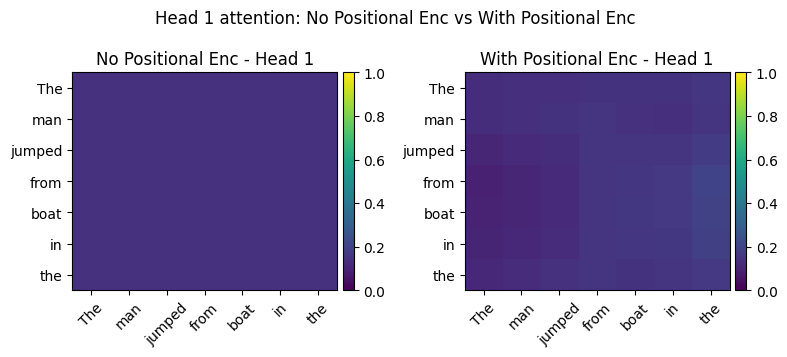

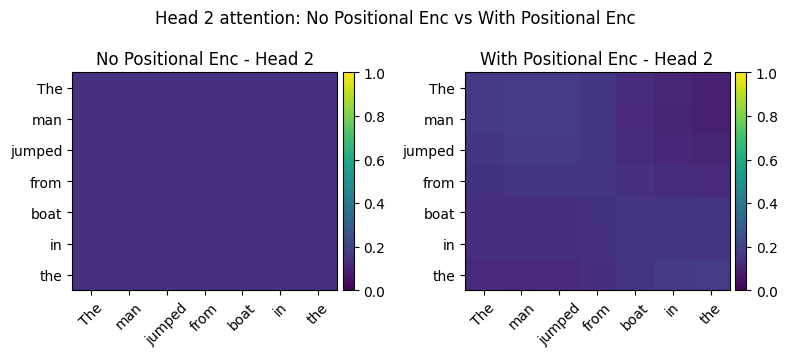

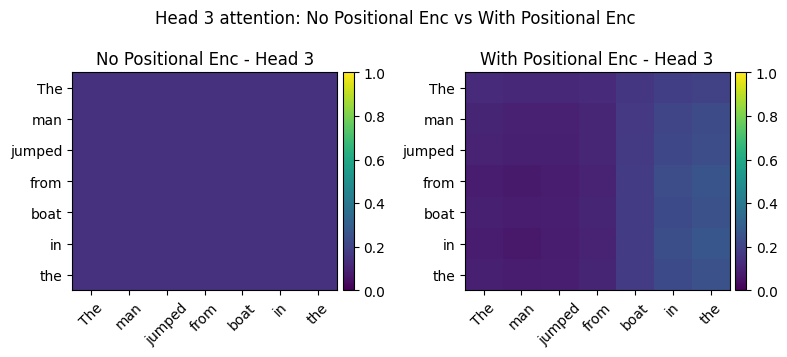

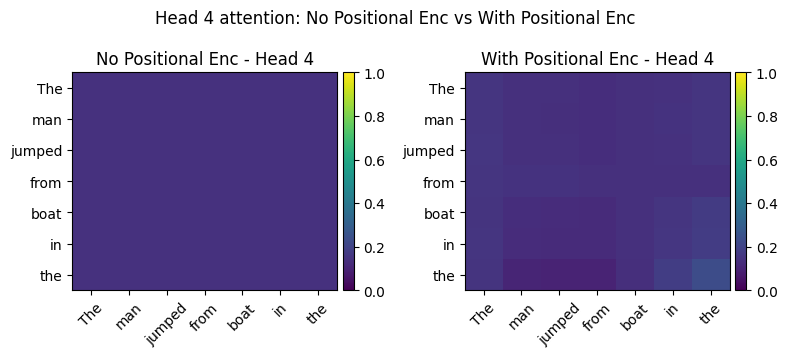


Probabilities at query position 0 (predicting token at pos 1):
Token        NoPE       WithPE
The          0.0004    0.0004
man          0.9957    0.9950
jumped       0.0009    0.0007
from         0.0007    0.0007
boat         0.0011    0.0001
in           0.0001    0.0005
the          0.0004    0.0011
river        0.0007    0.0016


In [3]:
# ---------------------------
# Visualize per-head side-by-side
# ---------------------------
def plot_side_by_side(att_a, att_b, tokens_labels, title_a="NoPE", title_b="PE"):
    num_heads = att_a.shape[0]
    for h in range(num_heads):
        fig, axes = plt.subplots(1, 2, figsize=(8,3.6))
        im0 = axes[0].imshow(att_a[h], vmin=0, vmax=1, cmap="viridis", aspect='auto')
        axes[0].set_title(f"{title_a} - Head {h+1}")
        axes[0].set_xticks(range(len(tokens_labels))); axes[0].set_xticklabels(tokens_labels, rotation=45)
        axes[0].set_yticks(range(len(tokens_labels))); axes[0].set_yticklabels(tokens_labels)
        fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.02)

        im1 = axes[1].imshow(att_b[h], vmin=0, vmax=1, cmap="viridis", aspect='auto')
        axes[1].set_title(f"{title_b} - Head {h+1}")
        axes[1].set_xticks(range(len(tokens_labels))); axes[1].set_xticklabels(tokens_labels, rotation=45)
        axes[1].set_yticks(range(len(tokens_labels))); axes[1].set_yticklabels(tokens_labels)
        fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.02)

        plt.suptitle(f"Head {h+1} attention: {title_a} vs {title_b}")
        plt.tight_layout()
        plt.show()

labels = tokens[:-1]  # positions corresponding to inputs
plot_side_by_side(att_nope, att_pe, labels, title_a="No Positional Enc", title_b="With Positional Enc")

# ---------------------------
# Print probabilities for a chosen query position to compare numeric effect
# ---------------------------
chosen_q = 0  # query position index (0..seq-1)
# Get logits from both models (call model to produce logits)
logits_nope = model_nope(inputs).numpy()[0]  # (seq, vocab)
logits_pe   = model_pe(inputs).numpy()[0]

probs_nope = scipy.special.softmax(logits_nope[chosen_q])
probs_pe   = scipy.special.softmax(logits_pe[chosen_q])

print(f"\nProbabilities at query position {chosen_q} (predicting token at pos {chosen_q+1}):")
print("Token".ljust(12), "NoPE".ljust(10), "WithPE")
for tok_idx, tok in enumerate(vocab):
    print(f"{tok.ljust(12)} {probs_nope[tok_idx]:.4f}    {probs_pe[tok_idx]:.4f}")

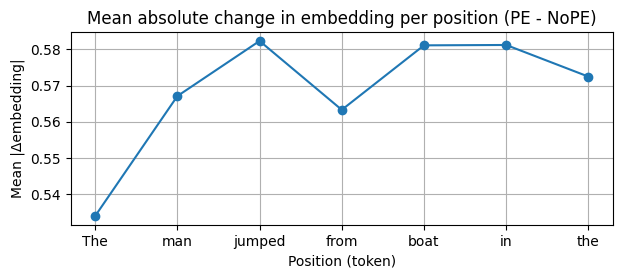

In [5]:
# ---------------------------
# Extra: visualize embeddings + positional encoding effect (optional)
# ---------------------------
# Show difference between embeddings (without PE) and with PE added, for first sample
if emb_nope.shape == emb_pe.shape:
    diff = emb_pe - emb_nope  # (batch, seq, d_model)
    # Plot mean absolute difference per position
    mean_abs_diff = np.mean(np.abs(diff[0]), axis=1)  # length seq
    plt.figure(figsize=(7,2.5))
    plt.plot(labels, mean_abs_diff, marker='o')
    plt.title("Mean absolute change in embedding per position (PE - NoPE)")
    plt.xlabel("Position (token)")
    plt.ylabel("Mean |Δembedding|")
    plt.grid(True)
    plt.show()

## The reason why we didn't see much difference in PE vs NoPE is that we have very small dataset and we trained also using very small architecture.